In [84]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Для начала соберем данные с сайта https://www.fanfiction.net/book/Harry-Potter/, а именно пройдемся по всем страницам и скачаем информацию о всех существующих фанфиках по Гарри Поттеру. Код, написанный мной, может это сделать, однако это займёт очень много времени. Поэтому я сделаю скрэппинг данных только за 2024-2020 год (этот скрэппинг занял 7 часов😭), а данные 2019-2004 возьму с сайта https://www.kaggle.com/datasets/nehatiwari03/harry-potter-fanfiction-data?resource=download. Данные на этом сайте также были получены скрэппингом того же сайта.

P.S: При парсинге был убран слишком откровенный контент, поэтому фанфики с рейтингом M не попали в список

Приведем датасеты в один вид и соединим их. Для этого переименуем столбцы, приведем содержимое столбцов в один формат данных и поменяем столбцы местами.

In [248]:
# скачиваем датасет 2020-2024
import pandas as pd
file = r'/content/gdrive/MyDrive/Colab Notebooks/fanfiction_data.csv'
df_new = pd.read_csv(file)

In [249]:
#скачиваем датасет 2004-2019
import pandas as pd
file = r'/content/gdrive/MyDrive/Colab Notebooks/hpcleanvlarge1.csv'
df_old = pd.read_csv(file)

In [250]:
import pandas as pd

#удаляем ненужные столбцы
del df_new['author_link']
del df_new['updated']
del df_old['Updated']
del df_old['published_mmyy']

#приводим к числовому виду
df_old['Words'] = df_old['Words'].astype(str).str.replace(',', '')

df_old['Favs'] = pd.to_numeric(df_old['Favs'], errors='coerce')
df_old['Follows'] = pd.to_numeric(df_old['Follows'], errors='coerce')
df_old['Reviews'] = pd.to_numeric(df_old['Reviews'], errors='coerce')
df_old['Words'] = pd.to_numeric(df_old['Words'], errors='coerce')

#заменяем Na на 0
df_old['Favs'] = df_old['Favs'].fillna(0)
df_old['Follows'] = df_old['Follows'].fillna(0)
df_old['Reviews'] = df_old['Reviews'].fillna(0)
df_old['Words'] = df_old['Words'].fillna(0)
df_new['favs'] = df_new['favs'].fillna(0)
df_new['follows'] = df_new['follows'].fillna(0)
df_new['reviews'] = df_new['reviews'].fillna(0)
df_new['words'] = df_new['words'].fillna(0)

# Переимновываем колонки, чтобы совпадали
column_renames = {
    'link': 'story_link',
    'summary': 'synopsis',
    'rated': 'rating',
    'reviews': 'Reviews',
    'chapters': 'Chapters',
    'favs': 'Favs',
    'follows': 'Follows',
    'published': 'Published',
    'words': 'Words',
}

df_new.rename(columns=column_renames, inplace=True)

В новый датасет нужно добавить столбец пейрингов путем выделения текста в квадратных скобках из столбца персонажей, для этого воспользуемся регулярными функциями.

In [251]:
import pandas as pd
import re
import numpy as np

def extract_pairings(characters):
    characters = str(characters)
    # Используем регулярные функции чтобы найти части текста в квадратных скобках
    pairings = re.findall(r'\[(.*?)\]', characters)
    return ', '.join(pairings) if pairings else np.nan

# Применяем функцию extract_pairings к столбцу «characters», чтобы создать столбец «painring»
df_new['pairing'] = df_new['characters'].apply(extract_pairings)

Важно заметить, что мы скачивали новые данные сверху вниз как они расположены на сайте, а на сайте они расположены по дате обновления. То есть в датасетах фанфики, которые были обновлены после 2019 года, попали в два датасета. Избавимся от дубликатов на оснвое параметров: автор, название, язык и дата публикации и оставим строчки именно из нового датасета, который мы скрэппили.

In [252]:
import pandas as pd

#Приводим к одному типу временных данных
df_new['Published'] = pd.to_datetime(df_new['Published']).dt.strftime('%m/%d/%Y')
df_old['Published'] = pd.to_datetime(df_old['Published']).dt.strftime('%m/%d/%Y')

# Ставим колонки в одинаковом порядке
df_new = df_new[df_old.columns]

# Соединяем датасеты
df = pd.concat([df_old, df_new])

#избавляемся от дубликатов
df.drop_duplicates(subset=['author', 'title', 'language', 'Published'], keep='last', inplace=True)

Мы получли готовый датасет, посмотрим на его параметры перед анализом

In [253]:
#фильтруем датасет от высоких рейтингов, так как мы хотим написать приличный фанфик
df = df[df['rating'] != 'M']

In [229]:
df.shape

(555051, 15)

In [190]:
df.dtypes

Chapters        int64
Favs          float64
Follows       float64
Published      object
Reviews       float64
Words           int64
author         object
characters     object
genre          object
language       object
rating         object
story_link     object
synopsis       object
title          object
pairing        object
dtype: object

In [191]:
df.head()

,Chapters,Favs,Follows,Published,Reviews,Words,author,characters,genre,language,rating,story_link,synopsis,title,pairing
0,1,2.0,0.0,12/31/2019,1.0,6840,reviews,"Sirius B., Remus L., James P., Regulus B.",Angst/Hurt/Comfort,English,T,https://www.fanfiction.net/s/13466909/1/If-You...,Regulus and James aren't happy. They know they...,If You Change Your Mind,NaN
4,1,4.0,3.0,12/31/2019,0.0,1529,Rowena-Moon-Moon,NaN,NaN,English,T,https://www.fanfiction.net/s/13466807/1/An-Und...,Harry makes a new discovery and perhaps a few ...,An Understanding,NaN
6,4,0.0,0.0,12/31/2019,0.0,2508,alixwolfix1,"James P., Lily Evans P., Remus L., Sirius B.",Sci-Fi,Spanish,K+,https://www.fanfiction.net/s/13466779/1/Herede...,La segunda temporada de Herederos de la magia....,Heredera Wolfix (Era de los Merodeadores),NaN
7,1,0.0,2.0,12/31/2019,1.0,4186,reviews,"Remus L., Regulus B.",Hurt/Comfort/Friendship,English,T,https://www.fanfiction.net/s/13466742/1/how-lu...,Remus has lost everything. Regulus is searchin...,how lucky we are (to be alive right now),NaN
8,1,3.0,3.0,12/31/2019,1.0,1304,reviews,"Harry P., Sirius B., OC",Family/Hurt/Comfort,English,T,https://www.fanfiction.net/s/13466735/1/A-Diff...,This is an AU for my original series. Same cha...,A Different Path Vol 1,NaN


# Гипотеза 1: Популярность фанфиков (измеряемая количеством избранных, подписчиков и обзоров) со временем возросла

Для начала давайте поймём популярны ли всё еще фанфики. Поэтому посмотрим на популярность фанфиков со временем, опираясь на показатели лайков, подписчиков и отзывов. Для этого группируем фанфики по годам, чтобы получить среднегодовые показатели

In [254]:
import numpy as np
df['Published'] = pd.to_datetime(df['Published'])

df['year'] = df['Published'].dt.year
df['month'] = df['Published'].dt.month


yearly_data = df.groupby('year').agg({
    'Favs': 'mean',
    'Follows': 'mean',
    'Reviews': 'mean'
}).reset_index()


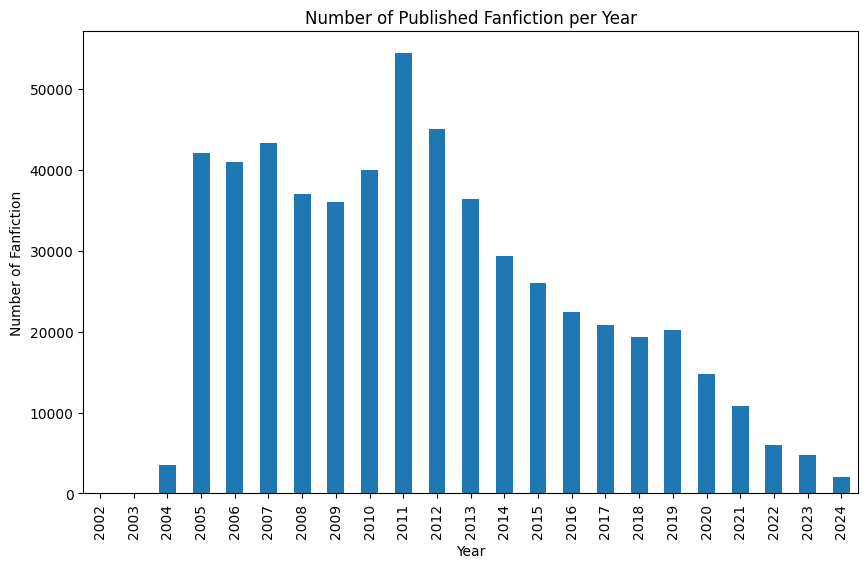

In [255]:
# Количество опубликованных фанфиков по годам
fanfics_per_year = df.groupby('year').size()

plt.figure(figsize=(10, 6))
fanfics_per_year.plot(kind='bar')
plt.title('Number of Published Fanfiction per Year')
plt.xlabel('Year')
plt.ylabel('Number of Fanfiction')
plt.show()

В первые года фанфиков было очень мало и они были востребованы, поэтому средняя популярность высокая, поэтому я не рассматриваю здесь 2002-2004 год, так как у них особая ситуация, чтобы лучше оценить последующие года

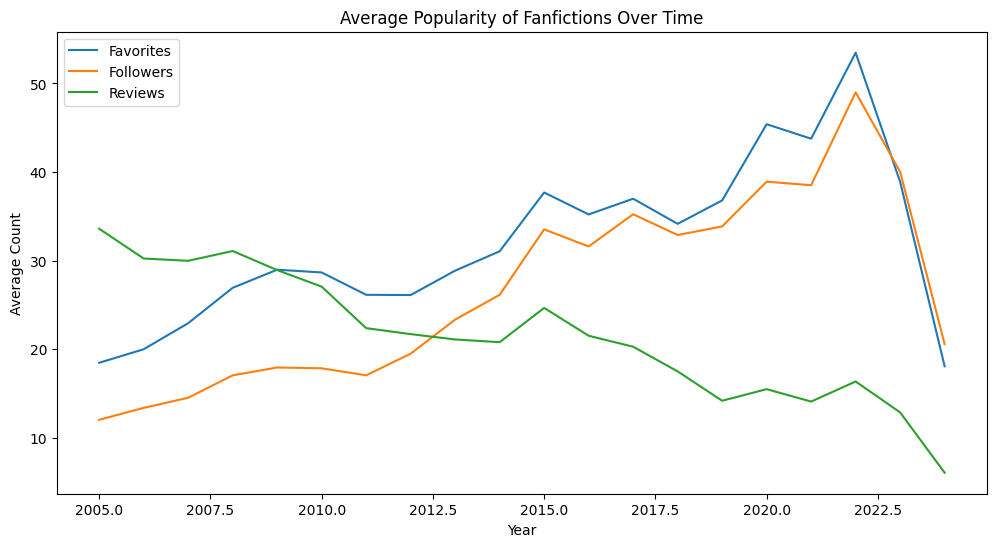

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_yearly_data = yearly_data[~yearly_data['year'].between(2002, 2004)]

plt.figure(figsize=(12, 6))

sns.lineplot(data=filtered_yearly_data, x='year', y='Favs', label='Favorites')
sns.lineplot(data=filtered_yearly_data, x='year', y='Follows', label='Followers')
sns.lineplot(data=filtered_yearly_data, x='year', y='Reviews', label='Reviews')
plt.title('Average Popularity of Fanfictions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Count')
plt.legend()
plt.show()


In [155]:
#удалить, корреляция года публикации и лайков
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(filtered_yearly_data['year'], filtered_yearly_data['Favs'])
print(f"Slope: {slope}, P-value: {p_value}, R-squared: {r_value**2}")


Slope: 1.0376844196493302, P-value: 0.0015811239478166845, R-squared: 0.434122565841474


 Видим, что количество лайков и подписчиков растет со временем, но резко падает в конце 2021 года. Однако также учтем тот факт, что чем новее фанфик, тем меньше у него лайков и подписчиков, потому что он еще не успел их набрать, поэтому очевидно, что новые фанфики будут иметь низкие покатели. Количество отзывов со временем снижается, значит прсото существует тенденция, что люди стали писать меньше отзывов. \\
 Наклон линейной регрессии положительный, а если убрать новые фанфики которые еще не успели набрать популярность, то он был бы еще больше. \\
 Я делаю вывод, что популярность фанфиков растёт, а значит нам точно стоит писать свой фанфик.

# Гипотеза 2: Более длинные фанфики более популярны

Теперь давайте определим какого размера фанфик лучше всего писать. Нужно понять писать длинный фанфик или короткий? Посмотрим на зависимость количества слов и количества лайков и зависимость количества слов и количества подписчиков. Для этого проведем регрессионый анализ, построим график рассеяния с линией регрессии и тепловую карту матрицы корреляций

In [137]:
import numpy as np
import statsmodels.api as sm

# Линейная регрессия между количеством слов и лайками
X = df['Words']
y_fav = df['Favs']
X = sm.add_constant(X)
model_fav = sm.OLS(y_fav, X).fit()
predictions_fav = model_fav.predict(X)

print(model_fav.summary())


                            OLS Regression Results                            
Dep. Variable:                   Favs   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                 5.336e+04
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:36:48   Log-Likelihood:            -3.5015e+06
No. Observations:              555051   AIC:                         7.003e+06
Df Residuals:                  555049   BIC:                         7.003e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5033      0.186     88.619      0.0

In [138]:
# Линейная регрессия между количеством слов и подписчиками
y_fol = df['Follows']
model_fol = sm.OLS(y_fol, X).fit()
predictions_fol = model_fol.predict(X)

print(model_fol.summary())

                            OLS Regression Results                            
Dep. Variable:                Follows   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                 5.643e+04
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        14:36:53   Log-Likelihood:            -3.5055e+06
No. Observations:              555051   AIC:                         7.011e+06
Df Residuals:                  555049   BIC:                         7.011e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3216      0.188     49.698      0.0

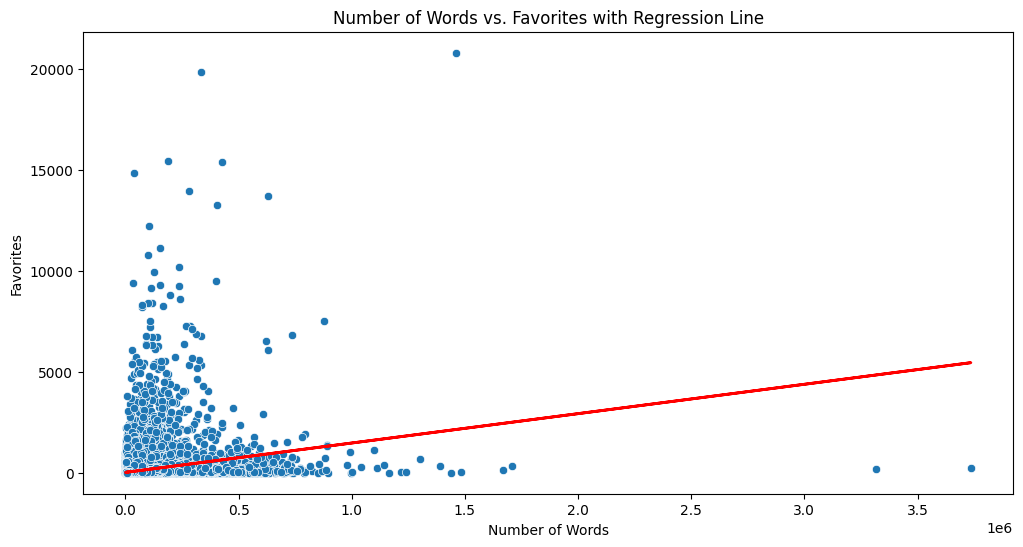

In [139]:
# График рассеяния с линией регрессии для лайков
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Words', y='Favs', data=df)
plt.plot(df['Words'], predictions_fav, color='red', linewidth=2)
plt.title('Number of Words vs. Favorites with Regression Line')
plt.xlabel('Number of Words')
plt.ylabel('Favorites')
plt.show()


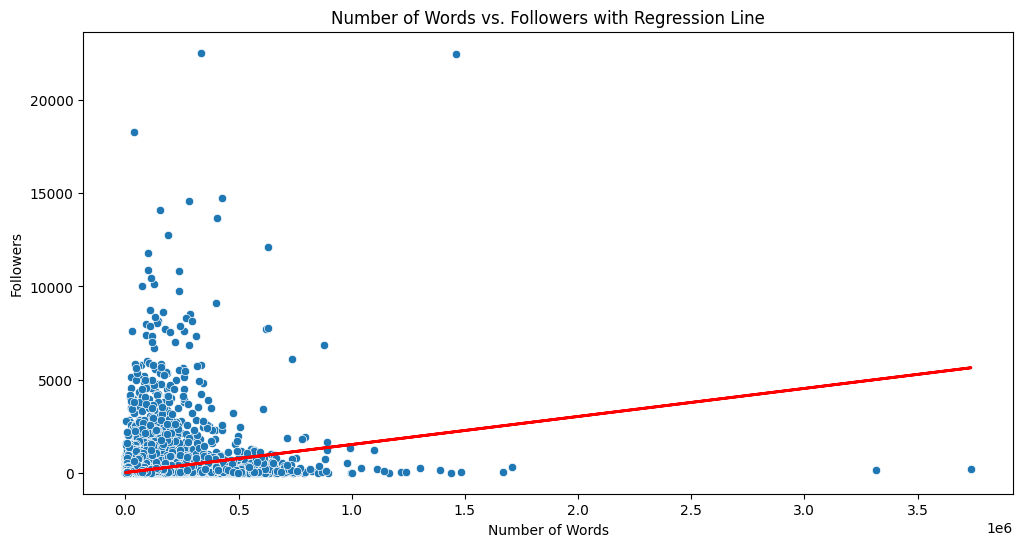

In [140]:
# График рассеяния с линией регрессии для подписчиков
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Words', y='Follows', data=df)
plt.plot(df['Words'], predictions_fol, color='red', linewidth=2)
plt.title('Number of Words vs. Followers with Regression Line')
plt.xlabel('Number of Words')
plt.ylabel('Followers')
plt.show()

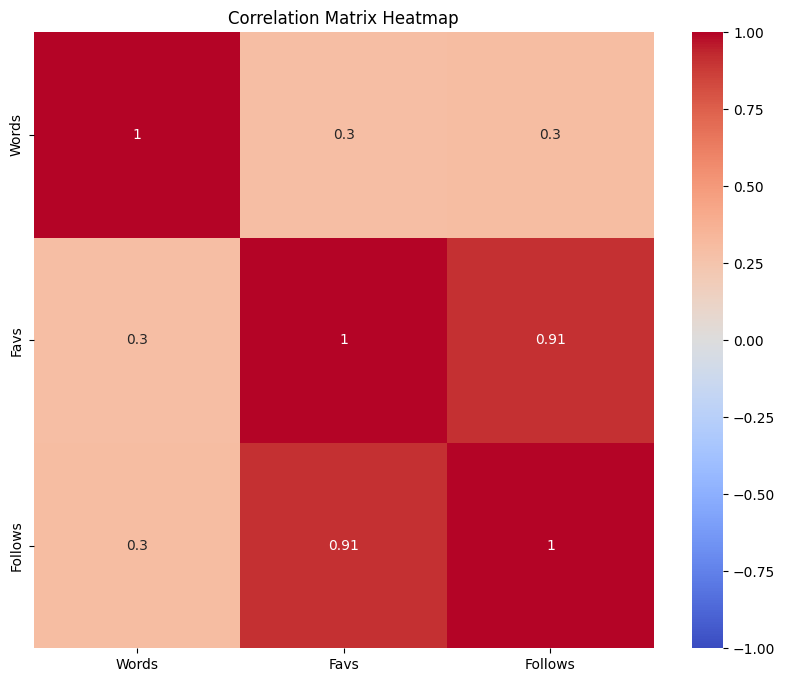

In [141]:
import seaborn as sns
import matplotlib.pyplot as plt

required_columns = ['Words', 'Favs', 'Follows']
data = df[required_columns].dropna()

corr_matrix = data.corr()

# Тепловая карта матрицы корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()


Рассмотрим регрессионный анализ: \\
Лайки: \\
R-квадрат = 0,088. Указывает на то, что примерно 8,8% разницы в количестве лайков можно объяснить количеством слов в фанфике. \\
P = 0,000. Это предполагает наличие положительной связи между количеством слов и количеством лайков. В частности, за каждое дополнительное слово в фанфике количество лайков увеличивается примерно на 0,0015.
Подписчики: \\
R-квадрат = 0,092 указывает на то, что примерно 9,2% разницы в количестве подписчиков можно объяснить количеством слов в фанфике. \\
P = 0,000. Это предполагает наличие положительной связи между количеством слов и количеством подписчиков. В частности, за каждое дополнительное слово в фанфике количество подписчиков увеличивается примерно на 0,0015. \\

\\
Корреляция между словами и лайками: 0,3 \\
Корреляция положительна и указывает на умеренную связь между количеством слов и количеством избранных. По мере увеличения продолжительности фанфика у него появляется больше фаворитов. \\
аналогично корреляция между словами и подписчиками: 0,3 \\
Эта положительная корреляция также указывает на умеренную связь между количеством слов и количеством подписчиков.

Общие выводы \\
Положительная связь : как регрессионный анализ, так и коэффициенты корреляции Пирсона указывают, что количество слов положительно влияет на количество лайков и подписчиков. Влияние небольшое, но статистически значимое. \\
Значения R-квадрата для обеих моделей относительно низкие (8,8% для Favsи 9,2% для Follows), что указывает на то, что, хотя количество слов является значимым предиктором, оно объясняет лишь небольшую часть изменчивости зависимых переменных. \\
В итоге можно сделать вывод, что фанфик не должен быть коротким, но и не должен быть длинным. На графике рассеивания, видно, что чаще всего получают много лайков фанфики в среднем с 0.2 - 0.3 млн слов.

# Гипотеза 3: Определенные персонажи и пары более популярны, чем другие.

Теперь нужно выяснить про какой пейринг писать фанфик, чтобы он стал наиболее популярным. Для этого построим граф с топ 25 популярными пейрингами, а затем узнаем, какие пейринги собрали в сумме больше всего лайков

Граф с топ 25 популярными пейрингами. Чем большее количество фанфиков написано  с этой парой, тем она популярнее. Чем пейринг популярнее, тем краснее ребро; чем менее, тем синее ребро.

[(('Draco M.', 'Hermione G.'), 26582), (('James P.', 'Lily Evans P.'), 20612), (('Draco M.', 'Harry P.'), 20266), (('Hermione G.', 'Ron W.'), 14730), (('Ginny W.', 'Harry P.'), 13855)]


<ipython-input-231-8781aeb4036f>:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Number of Mentions')


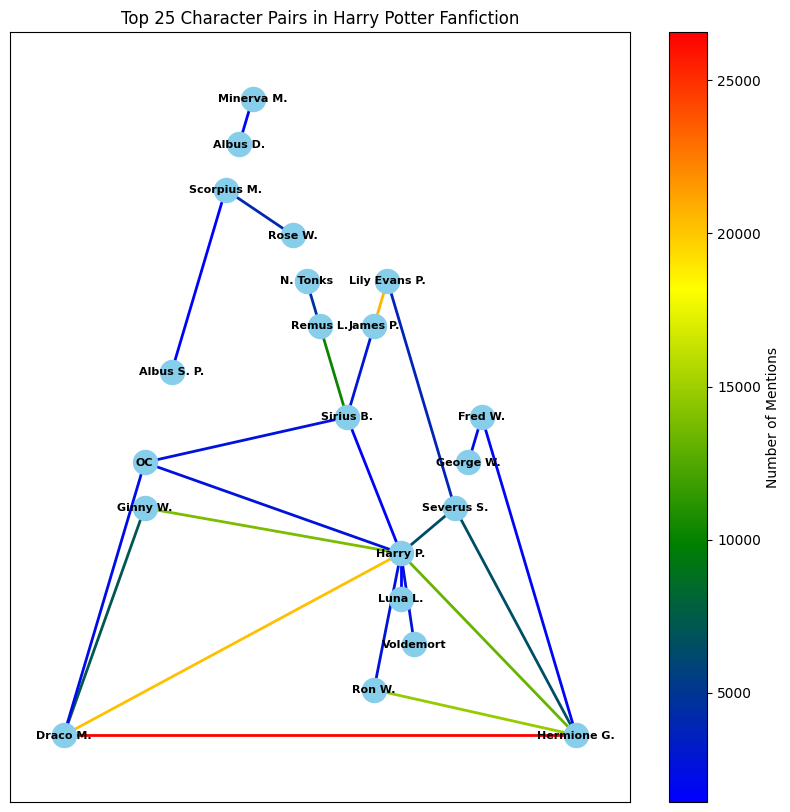

In [231]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
from matplotlib.colors import LinearSegmentedColormap

pairings_column = 'pairing'

pairings = df[pairings_column].dropna().tolist()

# Смотрим все возможные комбинации пар и для каждой пары проверяем вхождение в пейринги фанфика и суммируем лайки по каждому подходящему фанфику
pair_counter = Counter()
for pairing in pairings:
    characters = [char.strip() for char in pairing.split(',')]
    if len(characters) > 1:
        for combo in combinations(characters, 2):
            pair_counter[tuple(sorted(combo))] += 1

# Топ 25 пар
top_25_pairs = pair_counter.most_common(25)

G = nx.Graph()
for pair, count in top_25_pairs:
    G.add_edge(pair[0], pair[1], weight=count)

print(pair_counter.most_common(5))

# Определяем цвета ребер на основе веса
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_weight = min(edge_weights)

# Нормализуем веса между 0 и 1
normalized_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]

# Генерируем цветовую карту: от синего к зеленому, к желтому и к красному
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'green', 'yellow', 'red'])

# Генерация цветов: чем больше раз упоминается пара, тем краснее край; меньше раз, тем синее
edge_colors = [cmap(color) for color in normalized_weights]

# Исходный граф с планарной компоновкой
pos = nx.planar_layout(G)

def move_node(pos, node, x, y):
    pos[node] = (x, y)

plt.figure(figsize=(10, 10))
edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)
nodes = nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
labels = nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Цветная шкала
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm._A = []
plt.colorbar(sm, label='Number of Mentions')

plt.title("Top 25 Character Pairs in Harry Potter Fanfiction")
plt.show()


Видим, что самый популярный пейринг это Драмиона(Драко+Гермиона), но также популяны Драрри(Гарри+Драко), Джеймс+Лили, Гарии+Джинни, Рон+Гермиона. Теперь узнаем какие пейринги собирают больше всего лайков

In [232]:
import pandas as pd
from collections import Counter
from itertools import combinations


pairings_column = 'pairing'
favorites_column = 'Favs'

data = df

data[favorites_column] = pd.to_numeric(data[favorites_column], errors='coerce').fillna(0).astype(int)

# Инициализируем счетчик пар с общим количеством лайков
pair_likes_counter = Counter()


# Обработка столбца «pairing» для накопления лайков
for index, row in data.iterrows():
    values = row[pairings_column]
    if pd.notna(values):
        characters = [char.strip() for char in values.split(',')]
        if len(characters) > 1:
            likes = row[favorites_column]
            for combo in combinations(characters, 2):
                pair_likes_counter[tuple(sorted(combo))] += likes

# топ 5 пейрингов по сумме лайков
top_5_pairs_by_likes = pair_likes_counter.most_common(5)

print("Top 5 pairings by total likes:")
for pair, total_likes in top_5_pairs_by_likes:
    print(f"Pair: {pair}, Total Likes: {total_likes}")


Top 5 pairings by total likes:
Pair: ('Draco M.', 'Hermione G.'), Total Likes: 935075
Pair: ('Draco M.', 'Harry P.'), Total Likes: 721162
Pair: ('Harry P.', 'Hermione G.'), Total Likes: 686075
Pair: ('James P.', 'Lily Evans P.'), Total Likes: 482273
Pair: ('Harry P.', 'Severus S.'), Total Likes: 459930


Видим, что Драрри и Драмиона собирают больше всего лайков, но здесь появляется новый пейринг, который не отображен на графе как популярный, а именно Снарри(Снейп+Гарри). \\
Таким образом, я делаю вывод, что лучше писать про Снарри, так как количесвто работ с этим пейрингом не такое большое как у других, но сумма лайков большая, а следовательно, среднее количество лайков больше.

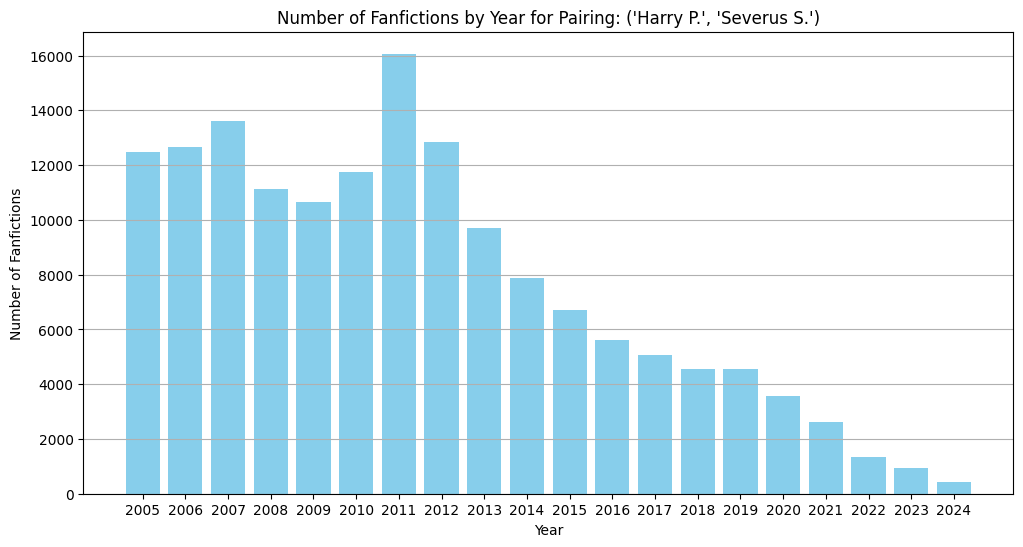

In [246]:
target_pairing = ('Harry P.', 'Severus S.')

def contains_target_pairing(pairing_list, target_pair):
    characters = [char.strip() for char in pairing_list.split(',')]
    return target_pair in combinations(characters, 2)

data = df
data['Published'] = pd.to_datetime(data['Published'])
data['year'] = data['Published'].dt.year
data = data[(data['year'] > 2004)]

filtered_data = data[data['pairing'].apply(lambda x: isinstance(x, str) and contains_target_pairing(x, target_pairing))]

# Count the number of fanfictions per year for the target pairing
fanfictions_per_year = filtered_df.groupby('year').size().reset_index(name='count')

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(fanfictions_per_year['year'], fanfictions_per_year['count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Fanfictions')
plt.title(f'Number of Fanfictions by Year for Pairing: {target_pairing}')
plt.xticks(fanfictions_per_year['year'].unique())
plt.grid(axis='y')

# Display the plot
plt.show()

# Гипотеза 4: Рейтинг фанфиков влияет на их популярность.

Теперь нужно выбрать какой использовать рейтинг для фанфика. Посмотрим как со временем изменялась популярность рейтингов и какой рейтинг в сумме набрал больше всего лайков

In [145]:
import pandas as pd

required_columns = ['Published', 'Favs', 'Follows', 'Reviews', 'rating']
dataf = df[required_columns].dropna()

dataf['Published'] = pd.to_datetime(dataf['Published'])
dataf['year'] = dataf['Published'].dt.year

# Группируем по рейтингу и году и рассчитываем среднегодовые показатели
grouped = dataf.groupby(['rating', 'year']).agg({
    'Favs': 'mean',
    'Follows': 'mean',
    'Reviews': 'mean'
}).reset_index()


<ipython-input-169-2e79378e20c6>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(ratings))
<ipython-input-169-2e79378e20c6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data['popularity_sum'] = rating_data['Favs'] + rating_data['Follows'] + rating_data['Reviews']
<ipython-input-169-2e79378e20c6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

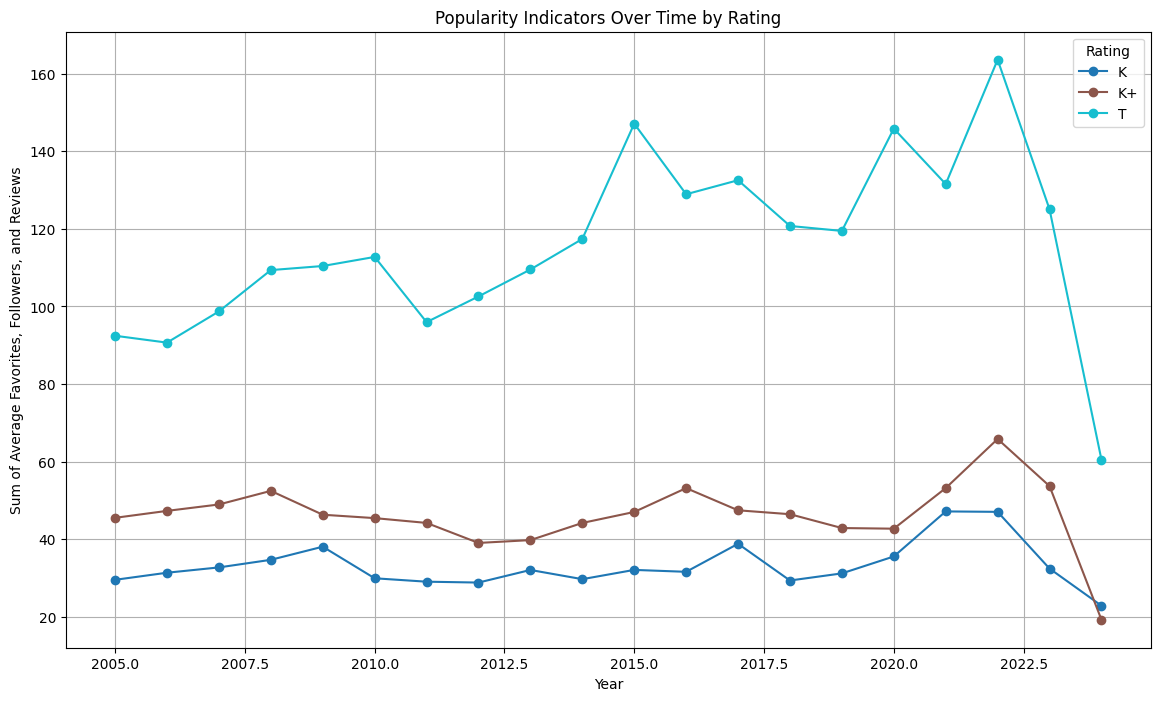

In [169]:
import matplotlib.pyplot as plt

# Строим график популярности(сумма лайков, подписчиков и отзывов) с течением времени для каждого рейтинга
plt.figure(figsize=(14, 8))

filtered_grouped = grouped[~grouped['year'].between(2002, 2004)]

# список уникальных рейтингов
ratings = filtered_grouped['rating'].unique()

# цвета
colors = plt.cm.get_cmap('tab10', len(ratings))

for idx, rating in enumerate(ratings):
    rating_data = filtered_grouped[filtered_grouped['rating'] == rating]

    # Суммируем данные (сумма избранных, подписчиков и отзывов)
    rating_data['popularity_sum'] = rating_data['Favs'] + rating_data['Follows'] + rating_data['Reviews']

    plt.plot(rating_data['year'], rating_data['popularity_sum'], marker='o', label=rating, color=colors(idx))

plt.title('Popularity Indicators Over Time by Rating')
plt.xlabel('Year')
plt.ylabel('Sum of Average Favorites, Followers, and Reviews')
plt.legend(title='Rating')
plt.grid(True)

plt.show()


Видим, что всегда популярнее рейтинг Т, значит именно этот рейтинг лучше всего использовать. Теперь посмотрим на суммарное количесвто лайков.

In [147]:
import pandas as pd

rating_column = 'rating'
favorites_column = 'Favs'

data = df
#приводим в числовой вид
data[favorites_column] = pd.to_numeric(data[favorites_column], errors='coerce').fillna(0).astype(int)

# Суммируем лайки для каждого рейтинга
rating_likes = dataf.groupby(rating_column)[favorites_column].sum()

# Отсортируйте рейтинги по количеству лайков в порядке убывания.
sorted_rating_likes = rating_likes.sort_values(ascending=False)

print("Ratings by total likes (in descending order):")
for rating, total_likes in sorted_rating_likes.items():
    print(f"Rating: {rating}, Total Likes: {total_likes}")


Ratings by total likes (in descending order):
Rating: T, Total Likes: 11278256
Rating: K+, Total Likes: 3004518
Rating: K, Total Likes: 1737459


опять же больше всего лайков собрал Т, поэтому точно он лучший для использования

Это график количества написанных фанфиков жанра T по годам

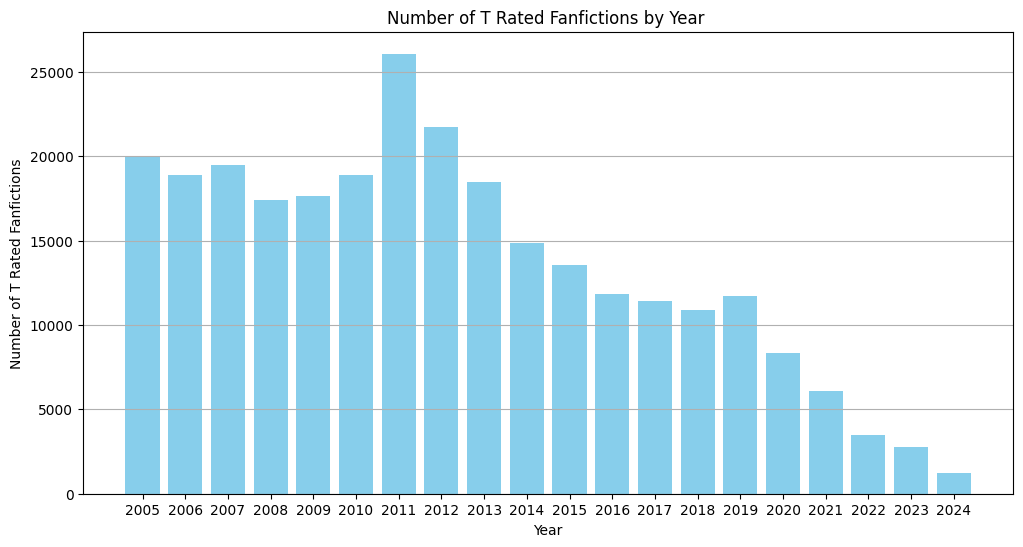

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the data to exclude 2002-2004 and include only T rating
rated = 'T'
data=df
data['Published'] = pd.to_datetime(data['Published'])
data['year'] = data['Published'].dt.year
filtered_df = data[(data['year'] > 2004) & (data['rating'] == rated)]

# Count the number of fanfictions per year
fanfictions_per_year = filtered_df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(12, 6))
plt.bar(fanfictions_per_year['year'], fanfictions_per_year['count'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of T Rated Fanfictions')
plt.title(f'Number of {rated} Rated Fanfictions by Year ')
plt.xticks(fanfictions_per_year['year'].unique())
plt.grid(axis='y')

# Display the plot
plt.show()

# Гипотеза 5: Жанр фанфиков влияет на их популярность.

Теперь нужно выбрать какой использовать жанр или список жанров. Посмотрим какая комбинация жанров приносит больше всего лайков

Функция get_all_combinations генерирует все возможные комбинации жанров.Код перебирает каждый фанфик, извлекает жанры и накапливает лайки для каждой комбинации жанров.
Код определяет комбинацию жанров, получившую наибольшее количество лайков, и печатает их.

In [148]:
import pandas as pd
from itertools import chain, combinations

genre_column = 'genre'
favorites_column = 'Favs'

data=df

#приводим в числовой вид
data[favorites_column] = pd.to_numeric(data[favorites_column], errors='coerce').fillna(0).astype(int)

# Все возможные кобинации жанров
def get_all_combinations(genres):
    return chain(*[combinations(genres, i) for i in range(1, len(genres) + 1)])

genre_combination_likes = {}

#Обработаем столбец «genre», чтобы накопить лайки для каждой комбинации
for index, row in data.iterrows():
    if pd.notna(row[genre_column]):
        genres = [genre.strip() for genre in row[genre_column].split('/')]
        likes = row[favorites_column]
        for combo in get_all_combinations(genres):
            combo_key = tuple(sorted(combo))
            if combo_key in genre_combination_likes:
                genre_combination_likes[combo_key] += likes
            else:
                genre_combination_likes[combo_key] = likes

# Лучшая комбинация
max_likes = max(genre_combination_likes.values())
best_genre_combinations = [combo for combo, likes in genre_combination_likes.items() if likes == max_likes]

print("Best genre combination(s) by total likes:")
for combo in best_genre_combinations:
    if len(combo) == 1:
        print(f"Genres: {combo[0]}, Total Likes: {max_likes}")
    else:
        print(f"Genres: {combo}, Total Likes: {max_likes}")


Best genre combination(s) by total likes:
Genres: Romance, Total Likes: 8246869


Значит выбираем Romance жанр

# Гипотеза 6: Наличие определенных ключевых слов в названии коррелирует с более высокой популярностью (лайки).

Нам нужно придумать название, а для этого нужно понять, важно ли, какие слова использовать. Построим облако слов, выъявив какие слова самые популярные, а затем с помощью регулярных функций посмотрим на корелляцию самых популярных слов и количество лайков

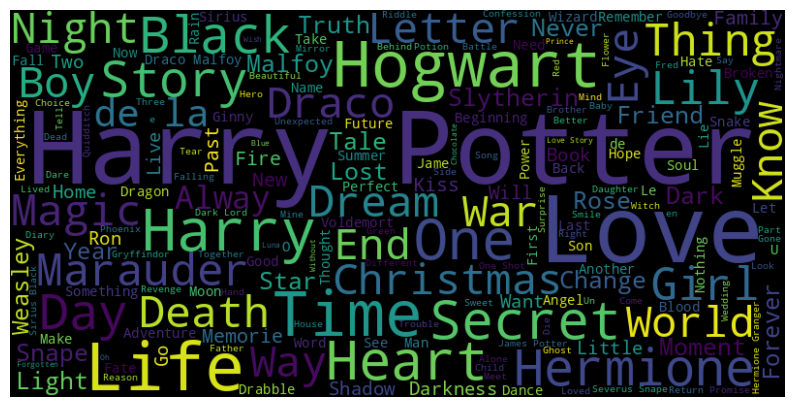

Correlation between keyword presence and favorites:                  keyword_present      Favs
keyword_present         1.000000  0.020871
Favs                    0.020871  1.000000


In [156]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Создание облака слов
text = ' '.join(df['title'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# ключевые слова
keywords = ['secret', 'hogwarts', 'Harry', 'love', 'life', 'time', 'heart']

# Использование регулярной функции чтобы найти ключевые слова в аннотации
def contains_keywords(text, keywords):
    pattern = '|'.join(keywords)  # Create a regex pattern
    return bool(re.search(pattern, str(text), re.IGNORECASE))

data['keyword_present'] = df['title'].apply(lambda x: contains_keywords(x, keywords))

# корелляция
corr = data[['keyword_present', 'Favs']].corr()
print("Correlation between keyword presence and favorites:", corr)


Корелляция положительная, но незначительная, значит употребление этих слов  может увеличиить популярность, но незначительно.

# Предсказательная модель

Построим предсказательную модель дерева решений, которая но основе жанра, языка и рейтинга фанфика будет предсказывать количество лайков. Построим гистограмму, показывающую важность каждого параметра для прогнозирования количества лайков. Функции с более высокими значениями важности оказывают большее влияние на прогнозы модели.

In [168]:
language_counts = df['language'].value_counts()
print("Список всех упоминающихся языков и количество их упоминаний:")
for language, count in language_counts.items():
  print (f" {language}: {count}")

Список всех упоминающихся языков и количество их упоминаний:
 English: 432549
 Spanish: 46487
 French: 39264
 Portuguese: 18232
 German: 8093
 Indonesian: 3133
 Polish: 2983
 Dutch: 757
 Swedish: 726
 Italian: 568
 Russian: 468
 Hungarian: 415
 Chinese: 355
 Czech: 312
 Finnish: 131
 Danish: 67
 Hebrew: 61
 Turkish: 58
 Catalan: 58
 Vietnamese: 48
 Norwegian: 43
 Slovak: 33
 Latin: 32
 Greek: 26
 Filipino: 23
 Croatian: 14
 Bulgarian: 13
 Korean: 13
 Esperanto: 12
 Romanian: 12
 Afrikaans: 11
 Japanese: 10
 Icelandic: 6
 Arabic: 6
 Farsi: 5
 Hindi: 5
 Ukrainian: 5
 Albanian: 4
 Serbian: 4
 Estonian: 4
 Malay: 3
 Devanagari: 1
 Thai: 1


Английский самый попуярный, будет больше всего читателей, поэтому пигем на нем.

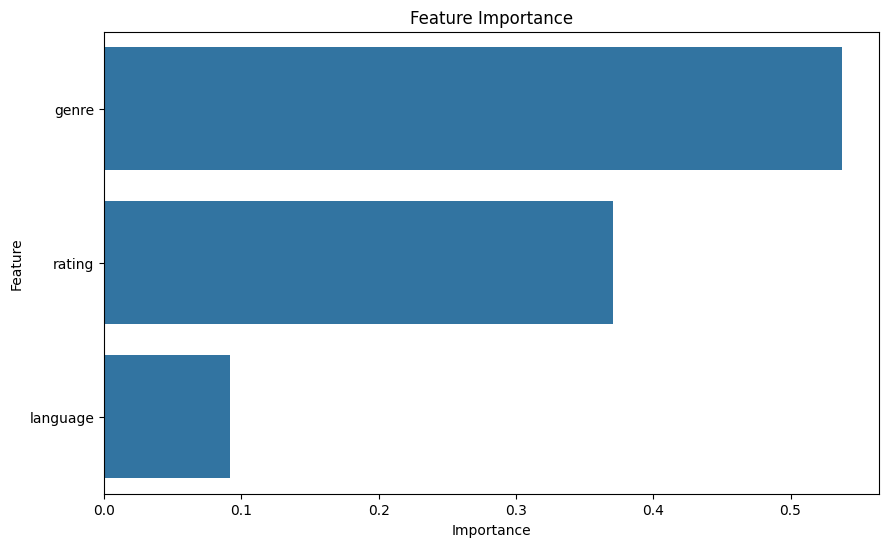

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

data = df

# подготовка данных
features = ['genre', 'language', 'rating']
X = pd.get_dummies(data[features])
y = data['Favs']

# разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# тренируем модель
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# предсказание
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# значимость характеристик
importance = model.feature_importances_

importances = pd.Series(importance, index=X.columns)
genre_importance = importances[X.columns.str.startswith('genre_')].sum()
rating_importance = importances[X.columns.str.startswith('rating_')].sum()
language_importance = importances[X.columns.str.startswith('language_')].sum()

combined_importance = importances[
    ~X.columns.str.startswith('genre_') &
    ~X.columns.str.startswith('rating_') &
    ~X.columns.str.startswith('language_')
]
combined_importance['genre'] = genre_importance
combined_importance['rating'] = rating_importance
combined_importance['language'] = language_importance

plt.figure(figsize=(10, 6))
sns.barplot(x=combined_importance.values, y=combined_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Видим, что больше всего влияет жанр. Далее проверим точность модели, оценим это по MSE. Сравним MSE нашей модели и MSE базовой модели , прогозирующей среднее значение лайков.

In [158]:
from sklearn.metrics import mean_squared_error
baseline_pred = y_train.mean()
baseline_mse = mean_squared_error(y_test, [baseline_pred] * len(y_test))

print(f"Model MSE: {mse}")
print(f"Baseline MSE (Mean Prediction): {baseline_mse}")


Model MSE: 15112.310691446577
Baseline MSE (Mean Prediction): 15386.988920466747


MSE нашей модели меньше, чем MSE базовой модели, следовательно, модель работает лучше, чем просто прогнозирование среднего значения целевой переменной, а значит можно считать, что наша модель применима. Тогда расчитаем примерное количество лайков на основе показателей, которые в ходе исследования мы получили как наиболее эффективные: \\
язык - английский, \\
жанр - романтика, \\
рейтинг - T.
Получаем в среднем 38.2 лайков, что в целом неплохо, тк среднее значение лайков по фанфикам равно  28.9

In [165]:
def predict_favs(language, genre, rating, model, feature_columns):
    input_data = pd.DataFrame({
        'genre': [genre],
        'rating': [rating],
        'language': [language]
    })

    input_data = pd.get_dummies(input_data)

    # Переиндексируем входные данные, чтобы они соответствовали столбцам обучающих данных
    input_data = input_data.reindex(columns=feature_columns, fill_value=0)

    # gрогноз, используя обученную модель
    predicted_favs = model.predict(input_data)

    return predicted_favs[0]

language = 'English'
genre = 'Romance'
rating = 'T'

feature_columns = X.columns

# Прогнозирование количества лайков
predicted_favs = predict_favs(language, genre, rating, model, feature_columns)
print(f"Predicted number of likes: {predicted_favs}")


Predicted number of likes: 38.14842199285431


In [166]:
df['Favs'].mean()

28.862632442784538